In [ ]:
pip install llvmlite

In [ ]:
pip install tsfresh --user

In [ ]:
pip install --upgrade numpy

In [ ]:
pip install numpy==1.20

In [57]:
# импортируем модули datetime, timedelta из библиотеки datetime для работы с функциями даты и времени

from datetime import datetime, timedelta

# импортируем библиотеку pandas - основную библиотеку Python для работы с данными
# эта библиотека активно используется аналитиками данных и дата-сайнтистами
# в этой библиотеке есть также модуль numpy - модуль для работы с многомерными массивами
# и модуль DataFrame для работы с датафреймами

import pandas as pd

# из библиотеки pandas импортируем модуль DataFrame для работы с датафреймами
# датафреймы - это структуры, аналогичные таблицам SQL, состоящие из строк и столбцов,
# но более мощные
# пример данных в DataFrame - любые таблицы с данными, временные ряды и т.д.

from pandas import DataFrame

# из библиотеки matlolib импортируем модуль pyplot для вывода графиков
# matlolib - популярная Python-библиотека для визуализации данных
# она используется для создания любых видов графиков:
# линейных, круговых диаграмм, построчных гистограмм и других — в зависимости от задач
# pyplot — это модуль в пакете Matplotlib для построения графиков
# в Matplotlib есть еще один популярный модуль - pylab
# он одновременно импортирует pyplot и библиотеку numpy для работы с массивами
# в интерактивном режиме или для доступа к функциям черчения при работе с данными

import matplotlib.pyplot as plt

# из библиотеки tinkoff.invest импортируем модули Client, RequestError, CandleInterval, HistoricCandle
# для подключения к инвестсчетам, работы с данными инвестсчетов,
# ценами активов и прочей инвестинформацией, к которой есть доступ у инвестсчёта

from tinkoff.invest import Client, RequestError, CandleInterval, HistoricCandle

# из модуля trend библиотеки ta импортируем функцию ema_indicator для построения скользящих средних
# модуль ta - это модуль для инвестиционного теханализа

from ta.trend import ema_indicator

import numpy as np

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 22,12

# from tsfresh import extract_features
# from tsfresh import extract_relevant_features

from datetime import datetime

GetAccountsResponse(accounts=[Account(id='2001260252', type=<AccountType.ACCOUNT_TYPE_TINKOFF: 1>, name='Брокерский счёт', status=<AccountStatus.ACCOUNT_STATUS_OPEN: 2>, opened_date=datetime.datetime(2018, 9, 9, 0, 0, tzinfo=datetime.timezone.utc), closed_date=datetime.datetime(1970, 1, 1, 0, 0, tzinfo=datetime.timezone.utc), access_level=<AccessLevel.ACCOUNT_ACCESS_LEVEL_FULL_ACCESS: 1>), Account(id='2004302036', type=<AccountType.ACCOUNT_TYPE_TINKOFF_IIS: 2>, name='ИИС', status=<AccountStatus.ACCOUNT_STATUS_OPEN: 2>, opened_date=datetime.datetime(2020, 5, 29, 0, 0, tzinfo=datetime.timezone.utc), closed_date=datetime.datetime(1970, 1, 1, 0, 0, tzinfo=datetime.timezone.utc), access_level=<AccessLevel.ACCOUNT_ACCESS_LEVEL_FULL_ACCESS: 1>), Account(id='2055404230', type=<AccountType.ACCOUNT_TYPE_TINKOFF: 1>, name='2в1 Рантье и Визионер RUB', status=<AccountStatus.ACCOUNT_STATUS_OPEN: 2>, opened_date=datetime.datetime(2023, 7, 11, 0, 0, tzinfo=datetime.timezone.utc), closed_date=datetime.

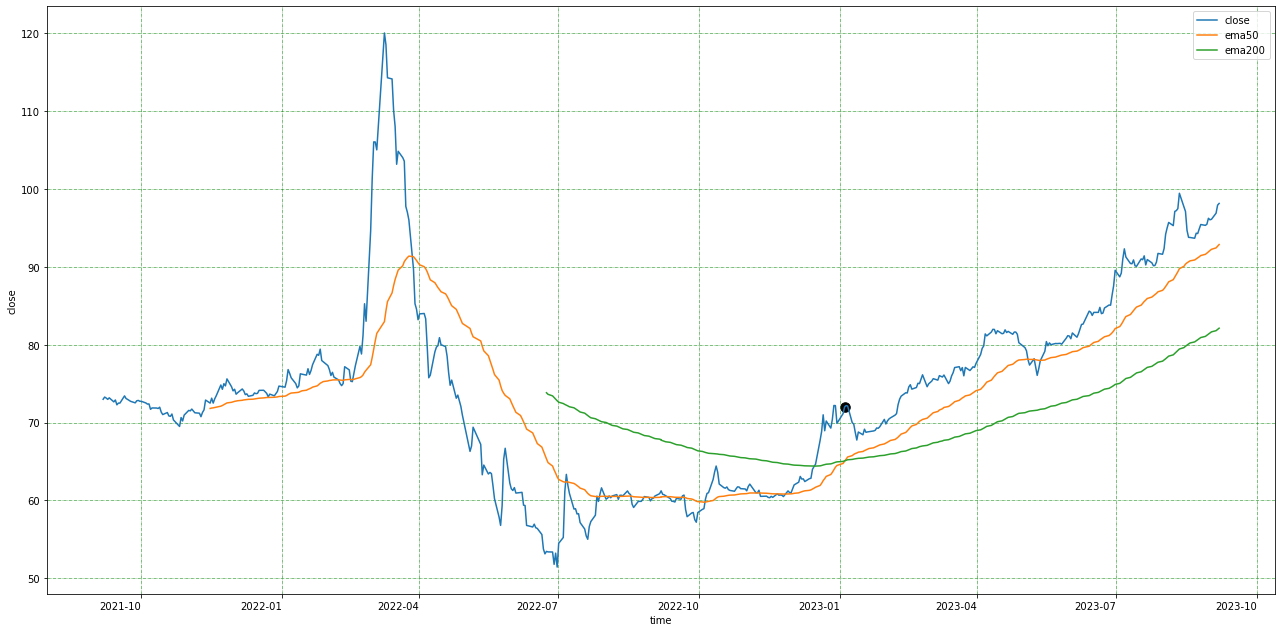

In [58]:
# Вставка своего API-ключа
token = pd.read_csv('token.txt')
token = token.columns[0]

# вывод номеров счетов

with Client(token) as client:
    print(client.users.get_accounts())

# функции (классы) для преобразования данных свечного графика и вывод графика актива + ema

# функция (класс) для формирования полей таблицы цен актива и определения типов данных
# без нее данные приходят массивом с некорректно читаемыми типами

def create_df(candles : [HistoricCandle]):
    df = DataFrame([{
        'time': c.time,
        'volume': c.volume,
        'open': cast_money(c.open),
        'close': cast_money(c.close),
        'high': cast_money(c.high),
        'low': cast_money(c.low),
    } for c in candles])

    return df

# функция (класс) определения типа данных цен актива
# без нее данные приходят массивом с некорректно читаемыми типами

def cast_money(v):
    """
    https://tinkoff.github.io/investAPI/faq_custom_types/
    :param v:
    :return:
    """
    return v.units + v.nano / 1e9 # nano - 9 нулей

# получаем свечи графика актива за указанный период

with Client(token) as client:
    response = client.users.get_accounts()
    accounts = [account.id for account in response.accounts]
    r = client.market_data.get_candles(
                figi='USD000UTSTOM',
                from_=datetime.utcnow() - timedelta(days=365) - timedelta(days=365),
                to=datetime.utcnow() - timedelta(days=365),
                interval=CandleInterval.CANDLE_INTERVAL_DAY # см. utils.get_all_candles
            )
   
  
df_old = create_df(r.candles)

with Client(token) as client:
    response = client.users.get_accounts()
    accounts = [account.id for account in response.accounts]
    r = client.market_data.get_candles(
                figi='USD000UTSTOM',
                from_=datetime.utcnow() - timedelta(days=365),
                to=datetime.utcnow(),
                interval=CandleInterval.CANDLE_INTERVAL_DAY # см. utils.get_all_candles
            )
   
# записываем полученные свечи графика актива за указанный период в датафрейм
   
df_new = create_df(r.candles)

df = pd.concat([df_old,df_new])
# добавляем в датафрейм с ценами актива за период поле ema со скользящей средней

df['ema50'] = ema_indicator(close=df['close'], window=50)
df['ema200'] = ema_indicator(close=df['close'], window=200)


# для нахождения пересечения
idx = np.argwhere(np.diff(np.sign(df.dropna()['ema50']- df.dropna()['ema200']))).flatten()
print(len(idx))
df_cross = df.dropna().reset_index(drop=True).iloc[list(idx)]


# выводим датафрейм с ценами актива за период и полем ema со скользящей средней

# print(df[['time', 'close', 'ema200', 'ema50']].tail(30))

ax = df.plot(x='time', y='close')
df.plot(ax=ax, x='time', y='ema50')
df.plot(ax=ax, x='time', y='ema200')
df_cross.plot(ax=ax,x='time', y='close', kind = 'scatter', color = 'black', s = 90, marker = 'o')
plt.grid(color='g', linestyle='-.', linewidth=0.5)
plt.show()

In [59]:
# подготовка данных - взяты после пересечения
df_after_cross = df[df.time >= str(df_cross['time'].values[0].astype('M8[D]').astype('O'))]
df_after_cross.reset_index(drop = True, inplace = True)

df_after_cross['date'] = df_after_cross['time'].dt.date
df_after_cross['year']  = df_after_cross['time'].dt.year
df_after_cross['month'] = df_after_cross['time'].dt.month
df_after_cross['week']  = df_after_cross['time'].dt.isocalendar().week
df_after_cross['day']   = df_after_cross['time'].dt.day

df_after_cross

<ipython-input-59-acd72ce70e86>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_after_cross['date'] = df_after_cross['time'].dt.date
<ipython-input-59-acd72ce70e86>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_after_cross['year']  = df_after_cross['time'].dt.year
<ipython-input-59-acd72ce70e86>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

,time,volume,open,close,high,low,ema50,ema200,date,year,month,week,day
0,2023-01-04 04:00:00+00:00,187537,71.6950,72.0000,72.1350,70.9000,65.036358,65.084400,2023-01-04,2023,1,1,4
1,2023-01-05 04:00:00+00:00,155297,72.0125,72.1800,72.2775,71.0200,65.316501,65.155003,2023-01-05,2023,1,1,5
2,2023-01-06 04:00:00+00:00,150236,71.8750,72.1225,72.4575,71.5225,65.583403,65.224331,2023-01-06,2023,1,1,6
3,2023-01-09 04:00:00+00:00,1346184,72.1750,69.9900,72.3000,69.3275,65.756211,65.271751,2023-01-09,2023,1,2,9
4,2023-01-10 04:00:00+00:00,850762,69.9875,69.8000,70.1500,69.2200,65.914790,65.316808,2023-01-10,2023,1,2,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,2023-08-31 04:00:00+00:00,805685,96.2350,96.0250,96.6550,95.6600,92.078850,81.495694,2023-08-31,2023,8,35,31
167,2023-09-01 04:00:00+00:00,953123,96.1550,96.0900,96.7375,95.8225,92.236150,81.640911,2023-09-01,2023,9,35,1
168,2023-09-04 04:00:00+00:00,724422,96.1400,96.8700,96.9525,96.1400,92.417870,81.792444,2023-09-04,2023,9,36,4
169,2023-09-05 04:00:00+00:00,785640,96.9000,97.9050,97.9500,96.9000,92.633051,81.952768,2023-09-05,2023,9,36,5


In [60]:
from scipy import signal
import numpy as np

y_coordinates = np.array(df_after_cross['close'])
peak_indices = signal.find_peaks(y_coordinates, prominence = 2 )
minimum_indices = signal.find_peaks(y_coordinates*-1, prominence = 2 )
peak_count = len(peak_indices)

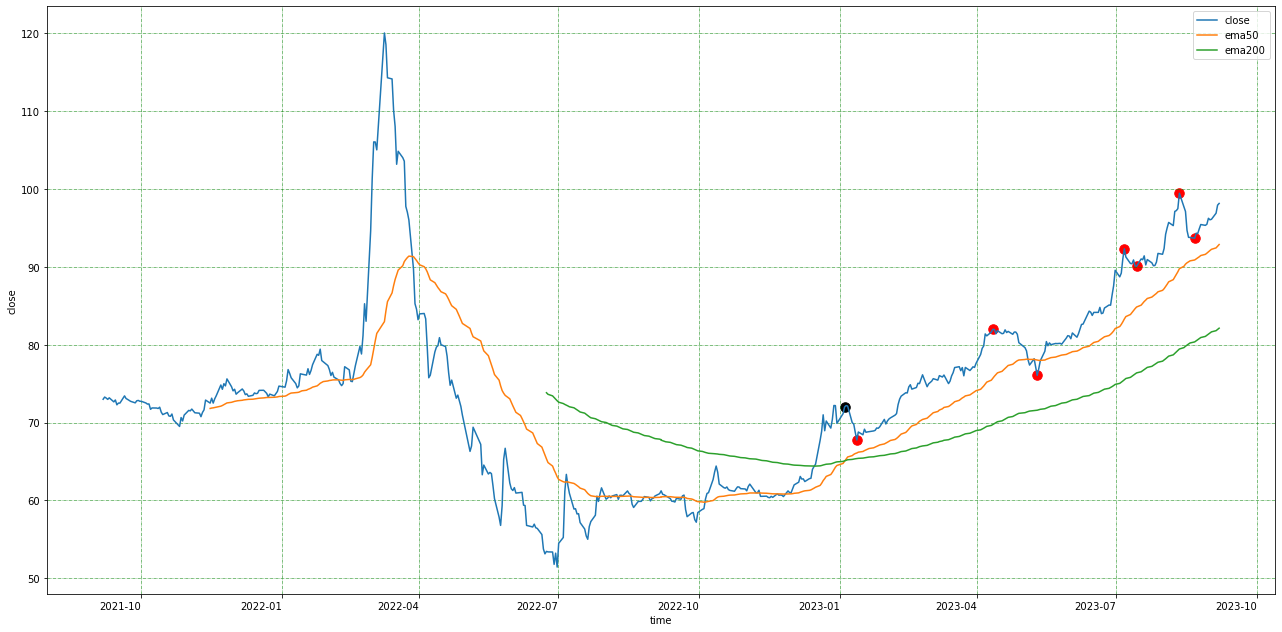

In [61]:
ax = df.plot(x='time', y='close')
df.plot(ax=ax, x='time', y='ema50')
df.plot(ax=ax, x='time', y='ema200')
df_cross.plot(ax=ax,x='time', y='close', kind = 'scatter', color = 'black', s = 90, marker = 'o')
df_after_cross.iloc[list(peak_indices[0])].plot(ax=ax,x='time', y='close', kind = 'scatter', color = 'red', s = 90, marker = 'o')
df_after_cross.iloc[list(minimum_indices[0])].plot(ax=ax,x='time', y='close', kind = 'scatter', color = 'red', s = 90, marker = 'o')
plt.grid(color='g', linestyle='-.', linewidth=0.5)
plt.show()

In [62]:
from sklearn.linear_model import LinearRegression

In [63]:
X = df_after_cross[['year','month','week','day']]
y = df_after_cross[['close']]

In [64]:
reg = LinearRegression()
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.931835081559687

In [66]:
df_after_cross['close_predict'] = reg.predict(X)
df_after_cross

<ipython-input-66-98fcc9738fec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_after_cross['close_predict'] = reg.predict(X)


,time,volume,open,close,high,low,ema50,ema200,date,year,month,week,day,close_predict
0,2023-01-04 04:00:00+00:00,187537,71.6950,72.0000,72.1350,70.9000,65.036358,65.084400,2023-01-04,2023,1,1,4,68.383350
1,2023-01-05 04:00:00+00:00,155297,72.0125,72.1800,72.2775,71.0200,65.316501,65.155003,2023-01-05,2023,1,1,5,68.284165
2,2023-01-06 04:00:00+00:00,150236,71.8750,72.1225,72.4575,71.5225,65.583403,65.224331,2023-01-06,2023,1,1,6,68.184981
3,2023-01-09 04:00:00+00:00,1346184,72.1750,69.9900,72.3000,69.3275,65.756211,65.271751,2023-01-09,2023,1,2,9,69.024486
4,2023-01-10 04:00:00+00:00,850762,69.9875,69.8000,70.1500,69.2200,65.914790,65.316808,2023-01-10,2023,1,2,10,68.925301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,2023-08-31 04:00:00+00:00,805685,96.2350,96.0250,96.6550,95.6600,92.078850,81.495694,2023-08-31,2023,8,35,31,94.321524
167,2023-09-01 04:00:00+00:00,953123,96.1550,96.0900,96.7375,95.8225,92.236150,81.640911,2023-09-01,2023,9,35,1,95.862234
168,2023-09-04 04:00:00+00:00,724422,96.1400,96.8700,96.9525,96.1400,92.417870,81.792444,2023-09-04,2023,9,36,4,96.701739
169,2023-09-05 04:00:00+00:00,785640,96.9000,97.9050,97.9500,96.9000,92.633051,81.952768,2023-09-05,2023,9,36,5,96.602554


In [71]:
x = df_after_cross.reset_index()['index']
y = df_after_cross['close']
z = np.polyfit (x, y, 1 )
p = np.poly1d (z)

#add trendline to plot
# plt.plot (df_after_cross['time'], p(x)) 

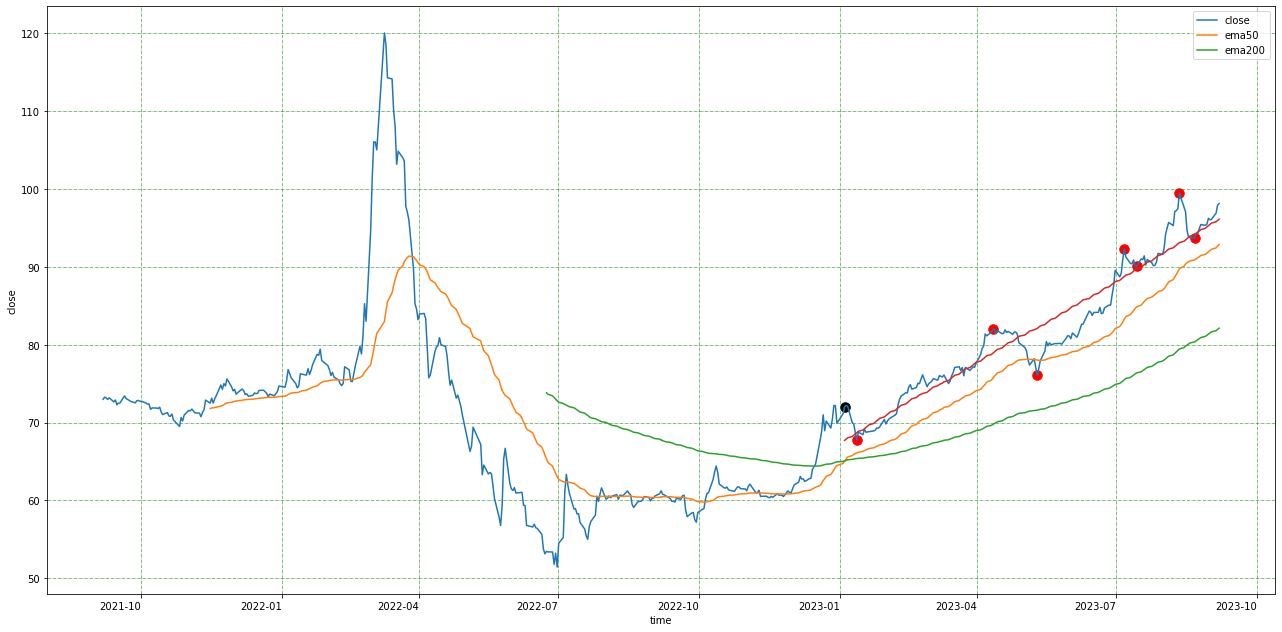

In [69]:
ax = df.plot(x='time', y='close')
df.plot(ax=ax, x='time', y='ema50')
df.plot(ax=ax, x='time', y='ema200')
df_cross.plot(ax=ax,x='time', y='close', kind = 'scatter', color = 'black', s = 90, marker = 'o')
df_after_cross.iloc[list(peak_indices[0])].plot(ax=ax,x='time', y='close', kind = 'scatter', color = 'red', s = 90, marker = 'o')
df_after_cross.iloc[list(minimum_indices[0])].plot(ax=ax,x='time', y='close', kind = 'scatter', color = 'red', s = 90, marker = 'o')
# df_after_cross.plot(ax=ax, x='time', y='close_predict')
plt.plot (df_after_cross['time'], p(x))
plt.grid(color='g', linestyle='-.', linewidth=0.5)
plt.show()

### Шлак и попытки

In [ ]:
X = extract_features(df_after_cross[['date','close','month']], column_id='month', column_sort = 'date')

In [ ]:
X

In [ ]:
X[[ 'close__maximum',
 'close__absolute_maximum',
 'close__minimum']]

In [ ]:
from scipy import signal
import numpy as np

y_coordinates = np.array(df_after_cross['close'])
peak_indices = signal.find_peaks(y_coordinates, prominence = 2 )
minimum_indices = signal.find_peaks(y_coordinates*-1, prominence = 2 )
peak_count = len(peak_indices)

In [ ]:
ax = df.plot(x='time', y='close')
df.plot(ax=ax, x='time', y='ema50')
df.plot(ax=ax, x='time', y='ema200')
df_cross.plot(ax=ax,x='time', y='close', kind = 'scatter', color = 'black', s = 90, marker = 'o')
df_after_cross.iloc[list(peak_indices[0])].plot(ax=ax,x='time', y='close', kind = 'scatter', color = 'red', s = 90, marker = 'o')
df_after_cross.iloc[list(minimum_indices[0])].plot(ax=ax,x='time', y='close', kind = 'scatter', color = 'red', s = 90, marker = 'o')
plt.grid(color='g', linestyle='-.', linewidth=0.5)
plt.show()

In [ ]:
list(peak_indices)

In [ ]:
list(X.columns)

In [ ]:
# from sklearn.linear_model import LinearRegression

In [ ]:
X = df_after_cross[['time']]
y = df_after_cross[['close']]

In [ ]:
LR = LinearRegression().fit(X, y)

In [ ]:
import statsmodels.formula.api as sm

In [ ]:
response = sm.ols(formula="close~close", data=df_after_cross).fit()
print(response.summary())

In [ ]:
response.predict()

In [ ]:
reg = LinearRegression().fit(X, y)
>>> reg.score(X, y)
1.0
>>> reg.coef_
array([1., 2.])
>>> reg.intercept_
3.0000...
>>> reg.predict(np.array([[3, 5]]))

In [ ]:
# Рекурсивная функция для поиска элемента пика в списке
def findPeak(nums, left=None, right=None):
 
    # Инициализация слева и справа
    if left is None and right is None:
        left, right = 0, len(nums) - 1
 
    # найти средний элемент. Чтобы избежать переполнения, используйте mid = left + (right - left) / 2
    mid = (left + right) // 2
 
    # проверяет, больше ли средний элемент, чем его соседи
    if ((mid == 0 or nums[mid - 1] <= nums[mid]) and
            (mid == len(nums) - 1 or nums[mid + 1] <= nums[mid])):
        return mid
 
    # Если левый сосед элемента `mid` больше, чем средний элемент,
    # рекурсивно находит пик в левом подсписке
    if mid - 1 >= 0 and nums[mid - 1] > nums[mid]:
        return findPeak(nums, left, mid - 1)
 
    # Если правый сосед `mid` больше, чем средний элемент,
    # рекурсивно находит пик в правом подсписке
    return findPeak(nums, mid + 1, right)
 
 
def findPeakElement(nums) -> int:
 
    # Базовый вариант
    if not nums:
        exit(-1)
 
    index = findPeak(nums)
    return nums[index]
 
 
if __name__ == '__main__':
 
    nums = [8, 9, 10, 2, 5, 6,10,11,1,2,3,4,5,6,12,0]
    print('The peak element is', findPeakElement(nums))

In [ ]:
import pandas as pd
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute

def find_extrema(df):
    # Шаг 1: Преобразование меток экстремумов в числовые значения
    label_mapping = {'min': -1, 'none': 0, 'max': 1}
    df['label'] = df['label'].map(label_mapping)

    # Шаг 2: Извлечение признаков временного ряда с помощью tsfresh
    extracted_features = extract_features(df, column_id='id', column_sort='time')

    # Шаг 3: Заполнение отсутствующих значений признаков
    imputed_features = impute(extracted_features)

#     # Шаг 4: Выбор наиболее информативных признаков
#     selected_features = select_features(imputed_features, df['label'], raise_exception=False)

    # Шаг 5: Идентификация точек экстремумов
    extrema = df[(df['id'].isin(extracted_features[extracted_features > 0].index))
                 & ((df['label'] == -1) | (df['label'] == 1))]

    # Шаг 6: Возврат найденных точек экстремумов
    return extrema

In [ ]:
# Пример временного ряда
df = pd.DataFrame({'id': [1, 1, 1, 2, 2, 2, 3, 3, 3],
                   'time': [1, 2, 3, 1, 2, 3, 1, 2, 3],
                   'value': [3, 2, 1, 4, 3, 2, 5, 4, 3],
                   'label': ['none', 'none', 'none', 'none', 'none', 'none', 'none', 'none', 'none']})

# Вызов функции для поиска экстремумов
extrema = find_extrema(df)

print("Найденные экстремумы:")
print(extrema)